In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1, 2, 3"
os.environ["NCCL_DEBUG"]="WARN"
#os.environ["NCCL_P2P_LEVEL"]="NODE"

In [2]:
import sys
sys.path.append("../../../")

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import omegaconf
import numpy as np
import matplotlib.pyplot as plt
from ganime.data.experimental import ImageDataset, VideoDataset
from ganime.model.vqgan_clean.vqgan import VQGAN
from ganime.visualization.videos import display_videos
from ganime.visualization.images import display_images
import tensorflow as tf
from datetime import datetime
from tqdm import tqdm
import os
from pyprojroot.pyprojroot import here
#tf.get_logger().setLevel('ERROR')

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.7.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [5]:
for device in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(device, True)

In [6]:
# strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


In [7]:
cfg = omegaconf.OmegaConf.load(here("configs/kny_image_full_vgg19_256_larger.yaml"))

In [8]:
num_workers = len(tf.config.list_physical_devices("GPU"))
batch_size = cfg["trainer"]["batch_size"] 
global_batch_size = batch_size * strategy.num_replicas_in_sync
n_epochs = cfg["trainer"]["n_epochs"] 
sample_batch_size = 8

In [9]:
dataset_length = 34045 # KNY
# dataset_length = 310153 #KNY full
#dataset_length = 20*10000 # MNIST
num_batch = dataset_length / batch_size

In [10]:
# Normalizing the images to [-1, 1]
def normalize(image):
    image = (tf.cast(image, tf.float32) / 127.5) - 1

    return image

In [11]:
def random_crop(image, img_height=64, img_width=128):
    cropped_image = tf.image.random_crop(image, size=[img_height, img_width, 3])

    return cropped_image

In [12]:
@tf.function()
def random_jitter(image):
    # Resizing to 72x142
    image = tf.image.resize(image, [288, 576], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # Random cropping back to 64x128
    image = random_crop(image, img_height=256, img_width=512)

    if tf.random.uniform(()) > 0.5:
        # Random mirroring
        image = tf.image.flip_left_right(image)

    return image

In [13]:
def preprocess(image):
    image = tf.reshape(image, (tf.shape(image)[0], tf.shape(image)[1], 3))
    image = random_jitter(image)
    image = normalize(image)
    return image, image

In [14]:
dataset = ImageDataset("../../../data/kny/images_tfrecords_light_256").load()
dataset = dataset.shuffle(dataset_length, reshuffle_each_iteration=True, seed=10).map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

In [15]:
train_size = int(dataset_length * 0.8)
validation_size = int(dataset_length * 0.1)
test_size = int(dataset_length * 0.1)

In [16]:
train_ds = dataset.take(train_size)
validation_ds = dataset.skip(train_size).take(validation_size)#.padded_batch(global_batch_size).map(postprocess)
test_ds = dataset.skip(train_size + validation_size).take(validation_size)#.padded_batch(global_batch_size).map(postprocess)

In [17]:
train_sample_data = next(train_ds
                          .batch(sample_batch_size)
                          .prefetch(tf.data.AUTOTUNE).as_numpy_iterator())
validation_sample_data = next(validation_ds.batch(sample_batch_size).as_numpy_iterator())

In [18]:
train_ds = (train_ds.batch(global_batch_size, drop_remainder=True)
            .prefetch(tf.data.AUTOTUNE))
validation_ds = (validation_ds.batch(global_batch_size, drop_remainder=True)
            .prefetch(tf.data.AUTOTUNE))
test_ds = (test_ds.batch(global_batch_size, drop_remainder=True)
            .prefetch(tf.data.AUTOTUNE))

In [19]:
train_sample_data[0].shape

(8, 256, 512, 3)

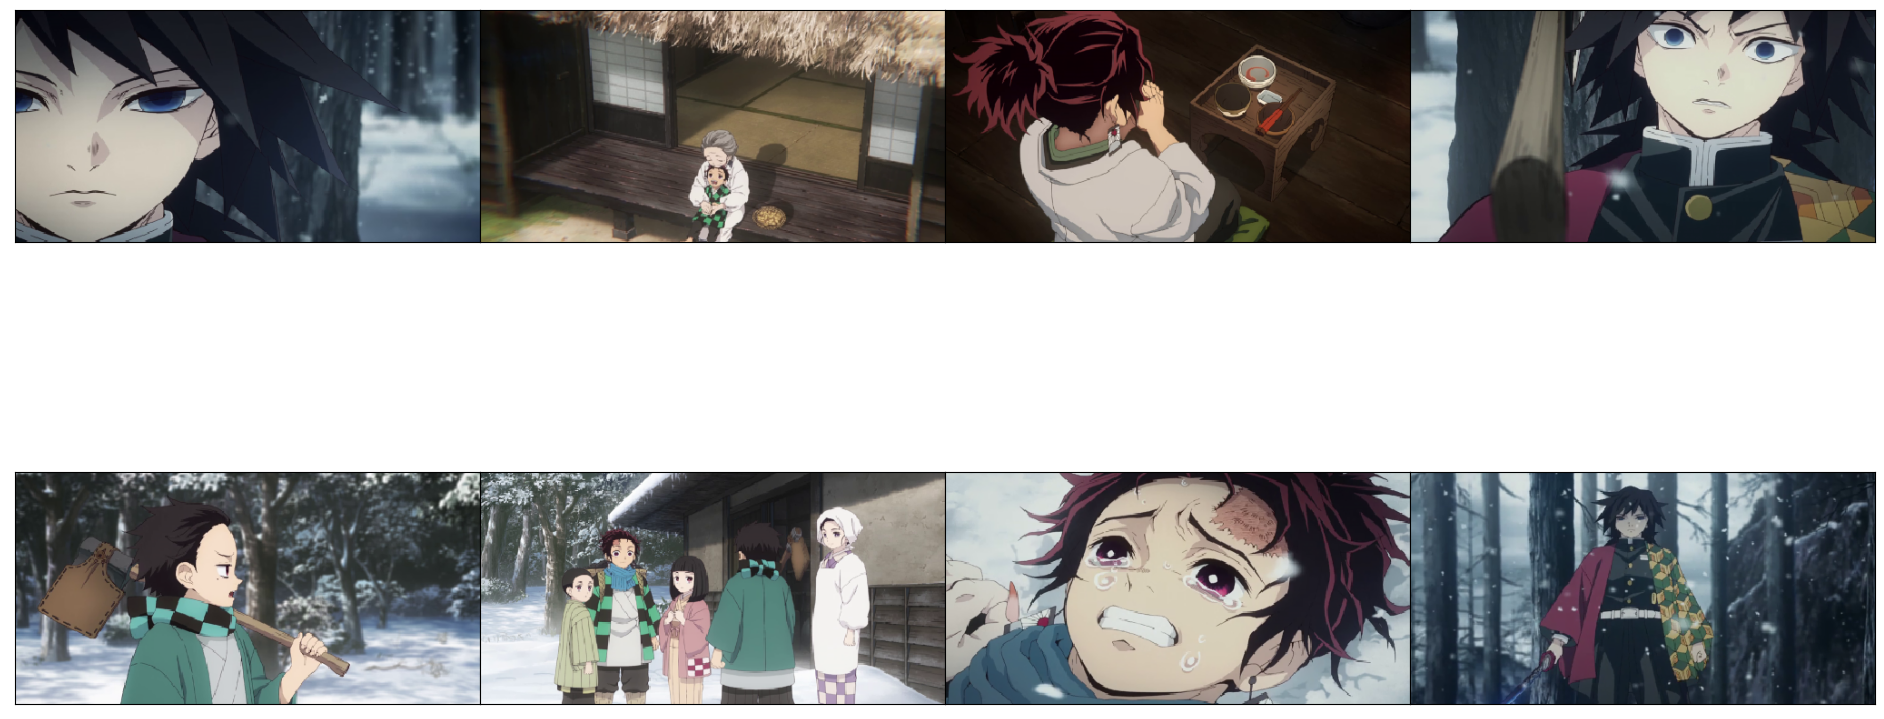

In [20]:
display_images(train_sample_data[0], n_rows=2, n_cols=4)

In [21]:
from ganime.utils.callbacks import TensorboardImage, get_logdir

logdir = get_logdir("../../../logs/ganime/vqgan", experiment_name="resolution_256_larger")
# Define the basic TensorBoard callback.
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
tensorboard_image_callback = TensorboardImage(logdir, train_sample_data, validation_sample_data)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_total_loss",
    min_delta=0.0001,
    patience=100,
    restore_best_weights=True,
)
checkpointing = tf.keras.callbacks.ModelCheckpoint(os.path.join(logdir, "checkpoint", "checkpoint"), monitor='val_reconstruction_loss', save_best_only=True, save_weights_only=True)
callbacks = [tensorboard_callback, tensorboard_image_callback, checkpointing]

In [22]:
# train_mean, train_var, train_std = dataset_statistics(train_ds)

In [23]:
from ganime.visualization.images import display_true_pred

In [21]:
with strategy.scope():
    vqgan = VQGAN(**cfg["model"], num_replicas=strategy.num_replicas_in_sync)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:loc

In [25]:
with strategy.scope():
    gen_optimizer = tf.keras.optimizers.Adam(
                learning_rate=cfg["trainer"]["gen_lr"],
                beta_1=cfg["trainer"]["gen_beta_1"],
                beta_2=cfg["trainer"]["gen_beta_2"],
                clipnorm=cfg["trainer"]["gen_clip_norm"],
    )
    disc_optimizer = tf.keras.optimizers.Adam(
        learning_rate=cfg["trainer"]["disc_lr"],
        beta_1=cfg["trainer"]["disc_beta_1"],
        beta_2=cfg["trainer"]["disc_beta_2"],
        clipnorm=cfg["trainer"]["disc_clip_norm"],
    )
    vqgan.compile(gen_optimizer=gen_optimizer, disc_optimizer=disc_optimizer)

In [ ]:
history = vqgan.fit(train_ds, validation_data=validation_ds, epochs=n_epochs, callbacks=callbacks)

Epoch 1/10000
INFO:tensorflow:batch_all_reduce: 209 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 13 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 209 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 13 all-reduces with algorithm = nccl, num_packs = 1
1134/1134 [==============================] - 1952s 2s/step - total_loss: 17.4366 - reconstruction_loss: 3.1374 - vq_loss: 14.2993 - disc_loss: 0.0000e+00 - val_total_loss: 39.6961 - val_reconstruction_loss: 2.8604 - val_vq_loss: 36.8357 - val_disc_loss: 0.0000e+00
Epoch 2/10000
1134/1134 [==============================] - 1731s 2s/step - total_loss: 53.3581 - reconstruction_loss: 2.7753 - vq_loss: 50.5828 - disc_loss: 0.0000e+00 - val_total_loss: 70.8958 - val_reconstruction_loss: 2.6740 - val_vq_loss: 68.2218 - val_disc_loss: 0.0000e+00
Epoch 3/10000
1134/1134 [==============================] - 1732s 2s/step - total_loss: 66.6092 -

In [23]:
generated = vqgan(train_sample_data[0])

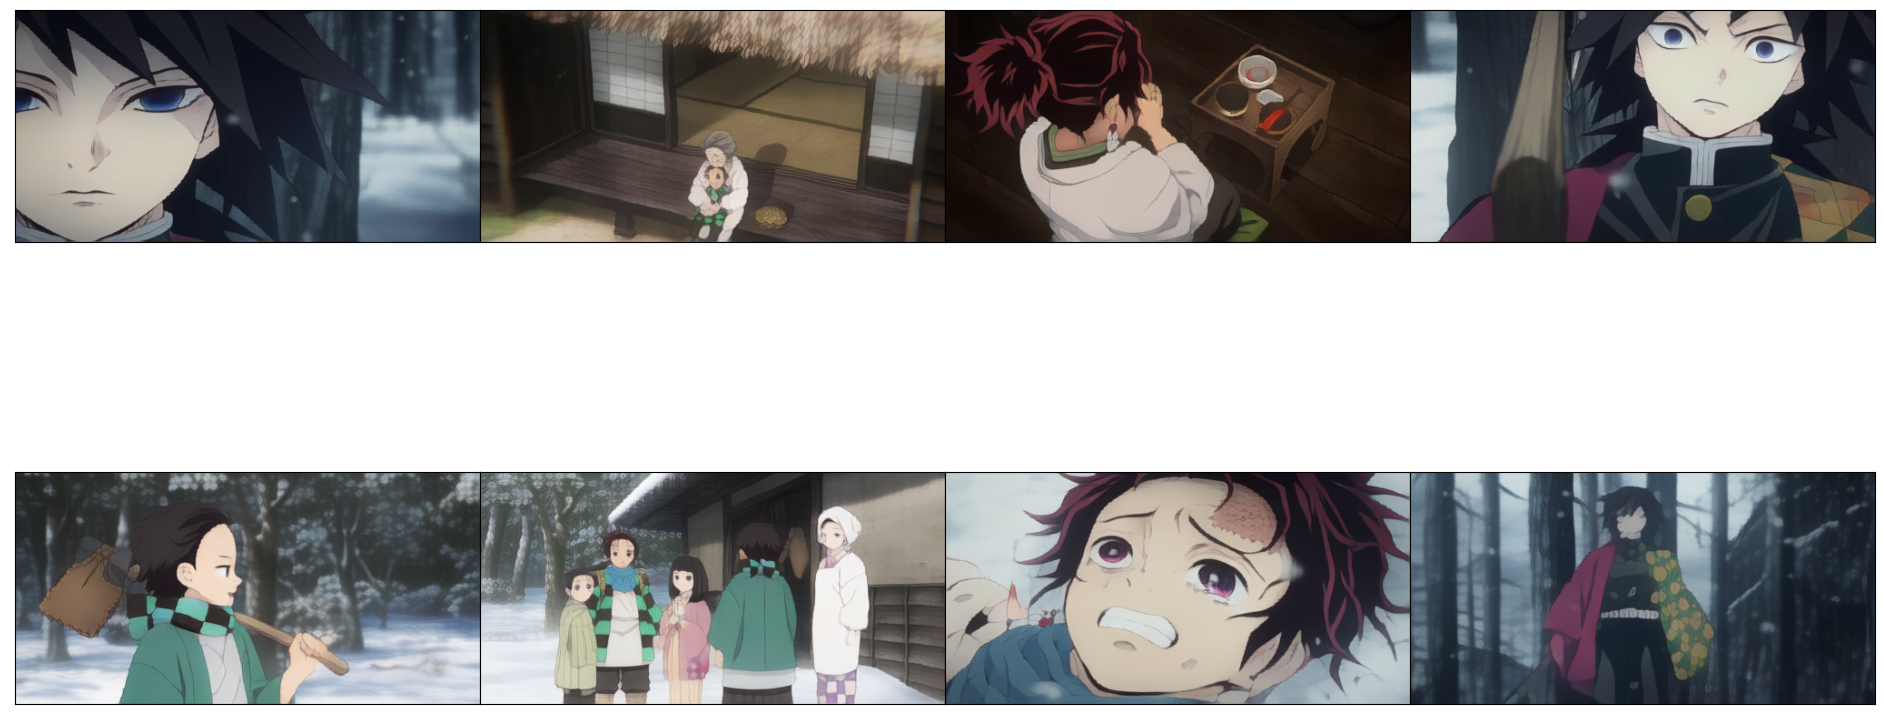

In [25]:
display_images(generated[0], n_rows=2, n_cols=4)